In [1]:
import numpy as np
import os
import cv2
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,datasets
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt

In [2]:
torch. cuda. device_count()

1

In [3]:
# move the model to GPU, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
transform = transforms.Compose([transforms.ToTensor()
                                ])

In [5]:
def load_img(img_path):
    img=cv2.imread(img_path)
    img=cv2.resize(img, (640,580))
    plt.figure()
    plt.imshow(img)
    img=Image.fromarray(img)
    img=transform(img)
    img=img.unsqueeze(0)
    return img

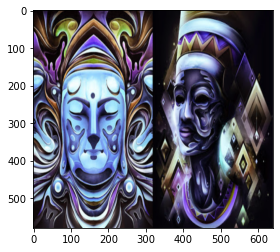

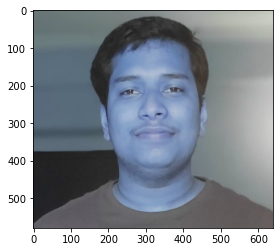

In [6]:
simg=load_img('D:/nst images/style15.jpg').to(device)
cimg=load_img('D:/nst images/content.jpg').to(device)
gimg=cimg.to(device)
gimg.requires_grad=True

In [7]:
def tensor_to_img(x):
    x=x[0]
    x=x.permute(1,2,0)
    x=x.detach()
    x=torch.clip(x,0.0,1.0)
    x=(x.cpu().numpy()*255).astype('uint8')
    return x

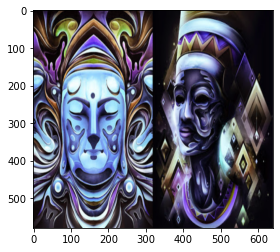

In [8]:
plt.imshow(tensor_to_img(simg))

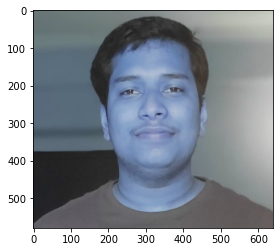

In [9]:
plt.imshow(tensor_to_img(cimg))

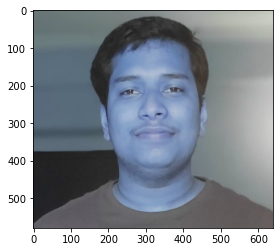

In [10]:
plt.imshow(tensor_to_img(gimg))

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.net=torchvision.models.vgg19(pretrained=True).features[:29]
        for param in self.net.parameters():
            param.requires_grad=False
        self.layers=[0,5,10,19,28]
        self.layer_outs={0:None,
                         5:None,
                         10:None,
                         19:None,
                         28:None}
        for i in self.layers:
            self.net[i].register_forward_hook(self.get_activ(i))
        
            
    def forward(self,x):
        return self.net(x)
    def get_activ(self,name):
        def activ_out(module,input,output):
            self.layer_outs[name]=output
        return activ_out

In [12]:
model=Net().to(device)
model

Net(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(

In [13]:
def content_loss(ca,ga):
    _, d, h, w = ca.size()
    content_loss=torch.mean((ca - ga)**2)
    return content_loss

In [14]:
def gram_matrix(a):
    _, d, h, w = a.size()
    a = a.view(d, h * w)
    gram = torch.mm(a, a.t())
    return gram 

In [15]:
def style_layer_loss(sa,ga):
    _, d, h, w = sa.size()
    sg=gram_matrix(sa)
    gg=gram_matrix(ga)
    factor=(1./(d*h*w))
    loss=factor*torch.mean((sg - gg)**2)
    return loss

In [16]:
def style_loss(sas,gas):
    #sas and gas are dictionary of activations
    loss=0
    for i in sas.keys():
        loss+=0.2*style_layer_loss(sas[i],gas[i])
    return loss

In [17]:
content_weight = 1
style_weight = 1e9

In [18]:
def total_loss(ca,ga,sas,gas):
    return content_weight*content_loss(ca,ga)+style_weight*style_loss(sas,gas)

In [19]:
#outputs for content and style image
cout=model(cimg)
c_layer_outs=model.layer_outs.copy()
sout=model(simg)
s_layer_outs=model.layer_outs.copy()

In [20]:
#making style and content inputs for lossess
ca=c_layer_outs[28]
ca=ca.detach()
sas=s_layer_outs
for i in sas.keys():
    sas[i]=sas[i].detach()

In [26]:
#defining loss and optimizer
criterion=total_loss
opt=torch.optim.Adam([gimg], lr=0.001)

In [29]:
#training
n_epochs=2000
for epoch in range(n_epochs):
    #gimg outputs
    gout=model(gimg)
    g_layer_outs=model.layer_outs.copy()
    #prepearing inputs to loss fn
    ga=g_layer_outs[28]
    gas=g_layer_outs
    #applying loss fn
    loss=criterion(ca,ga,sas,gas)
    opt.zero_grad()
    loss.backward()
    if (epoch+1)%10==0:
        print('_.',end="")
    if (epoch+1)%100==0:
        print("/ loss at eopch{}: {}".format(epoch+1+16000,loss))
        cv2.imwrite("D:/nst images/test{}.jpg".format(epoch+1+16000), tensor_to_img(gimg))
    opt.step()

_._._._._._._._._._./ loss at eopch16100: 31888384.0
_._._._._._._._._._./ loss at eopch16200: 31601298.0
_._._._._._._._._._./ loss at eopch16300: 31408864.0
_._._._._._._._._._./ loss at eopch16400: 31409178.0
_._._._._._._._._._./ loss at eopch16500: 31517620.0
_._._._._._._._._._./ loss at eopch16600: 31208148.0
_._._._._._._._._._./ loss at eopch16700: 30992812.0
_._._._._._._._._._./ loss at eopch16800: 30787162.0
_._._._._._._._._._./ loss at eopch16900: 30562530.0
_._._._._._._._._._./ loss at eopch17000: 30530360.0
_._._._._._._._._._./ loss at eopch17100: 30669904.0
_._._._._._._._._._./ loss at eopch17200: 30790398.0
_._._._._._._._._._./ loss at eopch17300: 30611060.0
_._._._._._._._._._./ loss at eopch17400: 30065978.0
_._._._._._._._._._./ loss at eopch17500: 30251182.0
_._._._._._._._._._./ loss at eopch17600: 30315308.0
_._._._._._._._._._./ loss at eopch17700: 30293586.0
_._._._._._._._._._./ loss at eopch17800: 29845050.0
_._._._._._._._._._./ loss at eopch17900: 2957

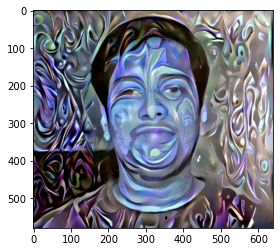

In [30]:
plt.imshow(tensor_to_img(gimg))

In [31]:
cv2.imwrite("test.jpg", tensor_to_img(gimg))

True

In [43]:
#Whole Procedure
from IPython.display import Video
Video("nst_video.mp4",width=240)

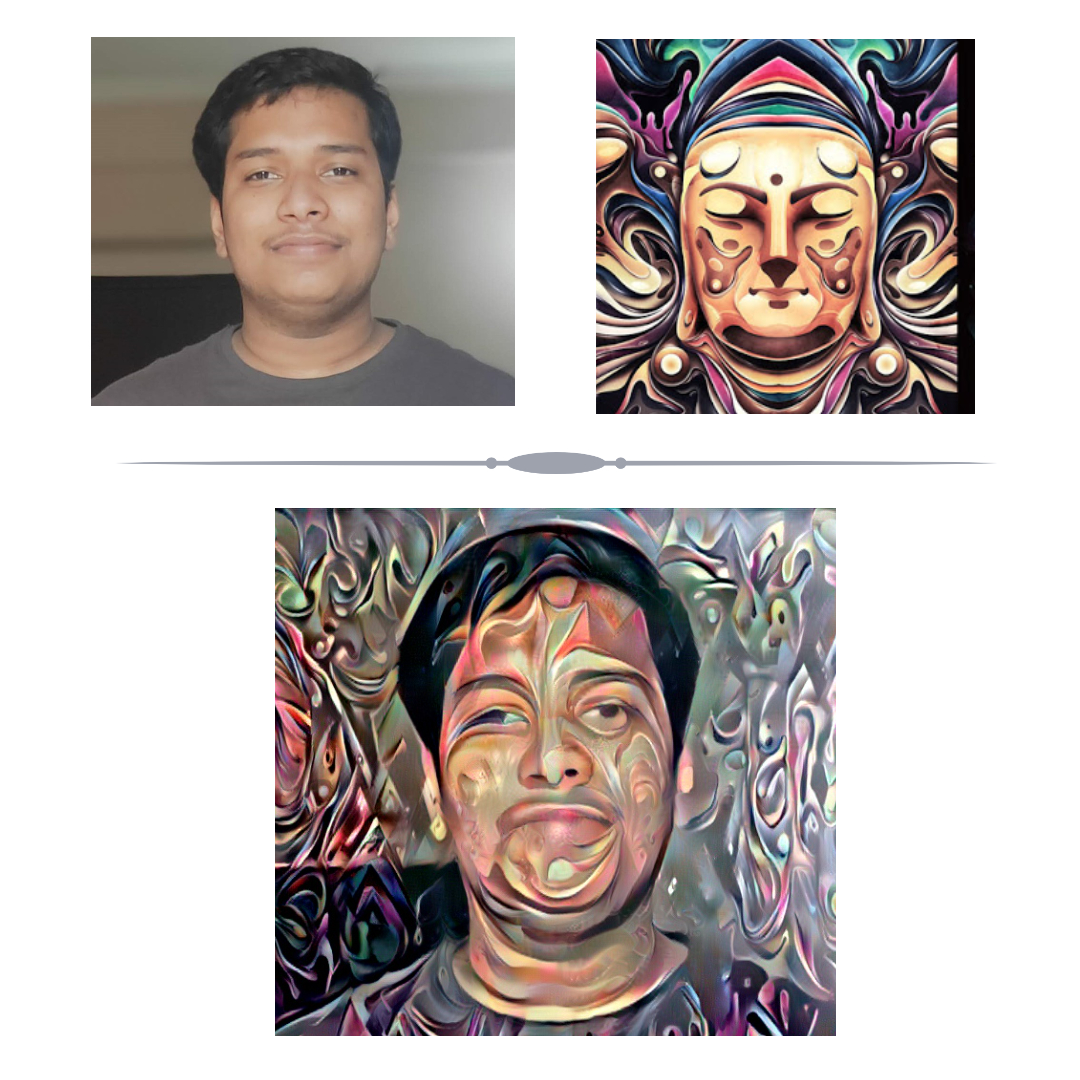

In [49]:
#Summary
from IPython.display import Image as Img
Img("D:/Downloads/nst desc.jpg",width=440)